# <font color=gray>**Topic Detection**</font>

## <font color=gray>**Objective**</font>

Identify health-related topics from conversational data like Twitter. The twitter data from various health news twitter handles is available below. Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00438/Health-News-Tweets.zip

## <font color=gray>**Task 2**</font>

Consider a topic called “tobacco use” and find sub-topics for the same. Take a subset of the tweets data below by filtering for the keywords “smoking,” “tobacco,” “cigarette,” “cigar,” “hookah,” and “hooka.” On this subset, implement topic detection/clustering and show the sub-topics detected by your approach (representative keywords or ngrams from the topics/cluster your method disovers)

### <font color=tan>**Steps Involved**</font>
 - **Import Dependencies**
 - **Import tweets data into a pandas dataframe**
 - **Filter tweets that belong to the sub topic "Tobacco Use"**
 - **Data Preprocessing**
     - Removing URLs and Usernames
     - Removing Stopwords and Stemming
     - Removing digits and short words (not abbreviations)
 - **Adding Bigrams/Trigrams**
 - **Building a dictionary and assigning numbers to words**
 - **Modelling Method**
     - LDA Python Implementation
     - Measuring Model Perforamnce
         - *Get Coherence Plots to get the optimum number of topics*
 - **Visualizing results**
     - Word Cloud for top 10 words/ngrams in a topic
     - Writing cluster output
     - pyLDAvis Visualization
 - **Conclusion**

 ### <font color=tan>**Import dependencies**</font>

In the first step we import all the dependencies.

You have to install the packages gensim, wordcloud and pyLDAvis if they are not currently installed.

In [201]:
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import string
import re

import gensim
from gensim.models import Phrases
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from numpy import array

import pyLDAvis.gensim

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

import time

### <font color=tan>**Import tweets data into a pandas dataframe**</font>
The downloaded data is saved in a folder "Health-Tweets" in the root directory. Let's download this data into a dataframe.I encountered several failures when I tried to read the data:
- some files use ISO-8859-1 encoding (Try and except block used to deal with this)
- some lines have '|' in the comments which is a delimiter for the file (I have skipped these lines for now using error_bad_lines = False)<br>

Finally we rename the columns of the data and our tweets data is ready.

In [202]:
files = glob.glob("Health-Tweets/*.txt")

data = pd.DataFrame({})
for i in files:
    try:
        data_i = pd.read_csv(i, 
                             sep ="|", 
                             header =  None,
                             error_bad_lines = False)
    except UnicodeDecodeError:
        print("Using ISO-8859-1 encoding for %s"%(i))
        data_i = pd.read_csv(i, 
                             sep ="|", 
                             header =  None,
                             error_bad_lines = False,
                             encoding = "ISO-8859-1")
    data = pd.concat([data, data_i], axis = 0)

data.columns = ['ID','Date','Comment']

data.reset_index(drop = True, inplace = True)

b'Skipping line 846: expected 3 fields, saw 4\nSkipping line 904: expected 3 fields, saw 4\nSkipping line 914: expected 3 fields, saw 4\nSkipping line 1264: expected 3 fields, saw 4\nSkipping line 1269: expected 3 fields, saw 4\nSkipping line 1293: expected 3 fields, saw 4\nSkipping line 1348: expected 3 fields, saw 4\nSkipping line 1430: expected 3 fields, saw 4\nSkipping line 1486: expected 3 fields, saw 4\nSkipping line 1710: expected 3 fields, saw 4\nSkipping line 2699: expected 3 fields, saw 4\nSkipping line 2728: expected 3 fields, saw 4\nSkipping line 3000: expected 3 fields, saw 4\n'
b'Skipping line 1422: expected 3 fields, saw 4\nSkipping line 1461: expected 3 fields, saw 4\nSkipping line 1468: expected 3 fields, saw 4\nSkipping line 1507: expected 3 fields, saw 4\nSkipping line 1547: expected 3 fields, saw 4\nSkipping line 1728: expected 3 fields, saw 4\nSkipping line 1738: expected 3 fields, saw 4\nSkipping line 1742: expected 3 fields, saw 4\nSkipping line 1847: expected 3 

Using ISO-8859-1 encoding for Health-Tweets\foxnewshealth.txt
Using ISO-8859-1 encoding for Health-Tweets\KaiserHealthNews.txt
Using ISO-8859-1 encoding for Health-Tweets\msnhealthnews.txt
Using ISO-8859-1 encoding for Health-Tweets\NBChealth.txt
Using ISO-8859-1 encoding for Health-Tweets\wsjhealth.txt


b'Skipping line 71: expected 3 fields, saw 4\nSkipping line 88: expected 3 fields, saw 4\nSkipping line 130: expected 3 fields, saw 4\nSkipping line 145: expected 3 fields, saw 4\nSkipping line 257: expected 3 fields, saw 4\nSkipping line 272: expected 3 fields, saw 4\nSkipping line 325: expected 3 fields, saw 4\nSkipping line 401: expected 3 fields, saw 4\nSkipping line 412: expected 3 fields, saw 4\nSkipping line 426: expected 3 fields, saw 4\nSkipping line 507: expected 3 fields, saw 4\nSkipping line 813: expected 3 fields, saw 4\nSkipping line 1319: expected 3 fields, saw 4\nSkipping line 1576: expected 3 fields, saw 4\nSkipping line 1592: expected 3 fields, saw 4\nSkipping line 1686: expected 3 fields, saw 4\nSkipping line 1929: expected 3 fields, saw 4\nSkipping line 2019: expected 3 fields, saw 4\nSkipping line 2359: expected 3 fields, saw 4\nSkipping line 2438: expected 3 fields, saw 4\nSkipping line 2679: expected 3 fields, saw 4\nSkipping line 2680: expected 3 fields, saw 4\n

In [20]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
print(data.shape)
data[0:15]

(62817, 3)


,ID,Date,Comment
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised http://bbc.in/1CimpJF
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll http://bbc.in/1ChTBRv
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater' http://bbc.in/1ChTANp
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising' http://bbc.in/1E6jAjt
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors http://bbc.in/1CnLwK7
5,585733482413891584,Wed Apr 08 09:18:39 +0000 2015,Review of case against NHS manager http://bbc.in/1Ffj6ci
6,585733481608646657,Wed Apr 08 09:18:39 +0000 2015,"VIDEO: 'All day is empty, what am I going to do?' http://bbc.in/1N7wSSz"
7,585701601131765761,Wed Apr 08 07:11:58 +0000 2015,VIDEO: 'Overhaul needed' for end-of-life care http://bbc.in/1CmrRu3
8,585620828110397440,Wed Apr 08 01:51:00 +0000 2015,Care for dying 'needs overhaul' http://bbc.in/1FdSGrl
9,585437294120677376,Tue Apr 07 13:41:42 +0000 2015,VIDEO: NHS: Labour and Tory key policies http://bbc.in/1Ci5eqD


### <font color=tan>**Filter tweets that belong to the sub topic "Tobacco Use"**</font>
Let's filter the tweets that contain the words "smoking”, “tobacco”, “cigarette”, “cigar”, “hookah”, and “hooka”.

In [203]:
#convert the docs to lowercase
doc_lower = data.Comment.str.lower()
data_tobacco = data[doc_lower.str.contains('smoking|tobacco|cigarette|cigar|hookah|hooka')]
print(data_tobacco.shape)
data_tobacco.head()

(824, 3)


,ID,Date,Comment
40,582687698772623361,Mon Mar 30 23:35:47 +0000 2015,E-cigarette use 'high among teens' http://bbc.in/1DhbCn6
106,578245454342680576,Wed Mar 18 17:23:54 +0000 2015,New global fund for tobacco control http://bbc.in/1GXRp4y
154,575700738459881472,Wed Mar 11 16:52:06 +0000 2015,MPs back standardised cigarette packs http://bbc.in/1HCTgwo
156,575683226250833920,Wed Mar 11 15:42:31 +0000 2015,Are anti-smoking measures working? http://bbc.in/1Fb1Enz
159,575467669828169728,Wed Mar 11 01:25:58 +0000 2015,Cigarette plain packaging vote due http://bbc.in/1Hy9aZ1


### <font color=tan>**Data Preprocessing**</font>
 - **Removing URLs** : Remove the URLs in the data using re.sub
 - **Removing Usernames** : Data has usernames that look like "@something". So, we remove them.
 - **Remove Stopwords** : We remove frequently occuring words like "the","him","your" and so on that do not add any value to the topic.
 - **Remove small words** : We remove small words which have less than 4 characters. Although a mojority of this would already be removed when we are removing the stop words but a few can be still three. We do not remove abbreviations like "HIV","CDC" which could essentially add value to the topic.
 - **Stemming** : We have to convert words to their root words to normalize the words. So, plays,playing and played all will be converted to the common root word play. We will use "PorterStemmer" to do the job for us. 
 
 We also remove the numbers from the data as it is unlikely to contribute to the topic and split the document into individual words.
 
 We have made a function docs_preprocessor that takes the array of comments as arguments and returns a list of lists as output. We will have a look at the output later.

In [204]:
def docs_preprocessor(docs):
    """
    Function to preprocess the tweets.
    """
    #remove website address from the tweets
    docs = [re.sub(r'http\S+', '', x, flags=re.MULTILINE) for x in docs]
    
    #remove usernames that start as 'RT @something'
    docs = [re.sub(r'RT @.*:', '', x, flags=re.MULTILINE) for x in docs]
    
    # Split into words.
    tokenizer = RegexpTokenizer(r'[-a-zA-Z0-9_]+')
    for idx in range(len(docs)):
        docs[idx] = tokenizer.tokenize(docs[idx])  

    # Remove stopwords
    stop = set(stopwords.words('english'))
    docs = [[token for token in doc if token not in stop] for doc in docs]
    
    # Remove numbers, but not words that contain numbers
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    #remove one letter tokens
    docs = [[token for token in doc if (len(token) > 1)] for doc in docs]
    
    # Remove small words that are not abbreviations(assuming abbreviations used are capitalized).
    docs = [[token for token in doc if (len(token) > 3) | (token.isupper())] for doc in docs]
    
    # Convert to lowercase
    docs = [[token.lower() for token in doc] for doc in docs]
    
    # Stemming all words in documents 
    # For words that contain hyphen(-) , the words are split and then stemming 
    #is applied to the split components and then the split components are joined
    #lemmatizer = WordNetLemmatizer() -- not being used
    porter = PorterStemmer()
    docs = [[porter.stem(token) if token.find('-') == -1 else 
             '-'.join([porter.stem(sub_token) for sub_token in token.split('-')])
             for token in doc] for doc in docs]
  
    return docs

In [205]:
docs = array(data_tobacco['Comment'])
docs = docs_preprocessor(docs)

In [206]:
data_tobacco['Comment'].head()

40     E-cigarette use 'high among teens' http://bbc.in/1DhbCn6   
106    New global fund for tobacco control http://bbc.in/1GXRp4y  
154    MPs back standardised cigarette packs http://bbc.in/1HCTgwo
156    Are anti-smoking measures working? http://bbc.in/1Fb1Enz   
159    Cigarette plain packaging vote due http://bbc.in/1Hy9aZ1   
Name: Comment, dtype: object

In [207]:
docs[0:5]

[['e-cigarett', 'high', 'among', 'teen'],
 ['global', 'fund', 'tobacco', 'control'],
 ['back', 'standardis', 'cigarett', 'pack'],
 ['anti-smoke', 'measur', 'work'],
 ['cigarett', 'plain', 'packag', 'vote']]

We can see the difference from the preprocessing.

### <font color=tan>**Adding Bigrams/Trigrams to documents**</font>
We add bigrams and trigrams to see the distribution of the combination of words in the document. We can see a few bigrams like **"Cigarette_pack"** and **"Global_fund"** could be useful for our analysis.

In [208]:
bigram = Phrases(docs, min_count = 5)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if token.count('_') == 1:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[bigram[docs[idx]]]:
        if token.count('_') == 2:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [209]:
data_tobacco['Comment'].head()

40     E-cigarette use 'high among teens' http://bbc.in/1DhbCn6   
106    New global fund for tobacco control http://bbc.in/1GXRp4y  
154    MPs back standardised cigarette packs http://bbc.in/1HCTgwo
156    Are anti-smoking measures working? http://bbc.in/1Fb1Enz   
159    Cigarette plain packaging vote due http://bbc.in/1Hy9aZ1   
Name: Comment, dtype: object

In [210]:
docs[0:5]

[['e-cigarett', 'high', 'among', 'teen'],
 ['global', 'fund', 'tobacco', 'control'],
 ['back', 'standardis', 'cigarett', 'pack', 'cigarett_pack'],
 ['anti-smoke', 'measur', 'work'],
 ['cigarett', 'plain', 'packag', 'vote']]

Looks like the bigrams and trigrams have been created. Lets proceed.

#### <font color=tan>Building a dictionary and assigning numbers to words</font>
We create a dictionary consisting of all the unique words that occur in our corpus/data. We remove the frequently occcuring words (greater than 40% of corpus) and rarely occuring words(frequency less than 5). 

We convert all the words to id/number and their repective counts in each document is present as a tuple.So, each tweet now is converted to a list of tuples (word_id, count_word_in_doc).

In [246]:
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(docs)

#Removing rare/common tokens
dictionary.filter_extremes(no_below = 10, no_above = 0.4)

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 118
Number of documents: 824
[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [247]:
word_mapping = pd.DataFrame.from_dict(dictionary.token2id, orient='index', columns=['ID'])
word_mapping.reset_index(inplace = True)
word_mapping.columns = ['Word','ID']

freq_count = pd.DataFrame.from_dict(dictionary.dfs, orient='index', columns=['Count'])
freq_count.reset_index(inplace = True)
freq_count.columns = ['ID','Count']

freq_corpus = word_mapping.merge(freq_count, on = 'ID')
freq_corpus = freq_corpus[['ID','Word','Count']]

Lets look at some of the words that occur in most of the documents. 

In [248]:
freq_corpus.sort_values(by = 'Count', ascending = False).head()

,ID,Word,Count
1,1,e-cigarett,189
4,4,tobacco,164
6,6,cigarett,163
58,58,studi,78
20,20,quit,78


Looks like the word **"tobacco"** occurs in **164/824** tweets where as the word **"e-cigarettes"** occurs in **189/824** tweets. <br> Looks like **e-cigarettes** are a lot popular these days.

Now, let's look at some of the most commonly occuring bigrams.

In [249]:
freq_corpus[freq_corpus.Word.str.contains('_')].sort_values(by = 'Count', ascending = False).head()

,ID,Word,Count
42,42,quit_smoke,51
7,7,cigarett_pack,18
110,110,studi_find,15
67,67,tobacco_product,12
111,111,studi_say,12


**"quit_smoking"** and **"cigarette_pack"** are the most commonly occuring bigrams. We will skip the trigrams for now.

Looks like we are ready to implement our sub-topic model now.

### <font color=tan>Modelling Method</font>
We will use **LDA (latent Dirichlet allocation)** for our topic modelling exercise. In this method each document is assumed to be a collection of topics and each topic is assumed to be a collection of words.

In more detail, LDA represents documents as mixtures of topics that spit out words with certain probabilities. It assumes that documents are produced in the following fashion:

- Decide on the number of words N the document will have.
- Choose a topic mixture for the document (from fixed set of K topics). 
- First picking a topic
- Using the topic to generate the word itself (according to the topic’s word distribution)
Assuming this generative model for a collection of documents, LDA then tries to backtrack from the documents to find a set of topics that are likely to have generated the collection.

Fo more insights on the LDA method, feel free to visit this site [(LDA)](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/).

### <font color=tan>LDA Python Implementation</font> 
We will use the gensim package to run LDA.

**ldamodel = Lda(corpus, id2word, num_topics, random_state, update_every, chunksize, passes, alpha, per_word_topics)**

**Parameters:**	
- **corpus** – Stream of document vectors or sparse matrix of shape (num_terms, num_documents). If not given, the model is left untrained (presumably because you want to call update() manually).
- **num_topics** – The number of requested latent topics to be extracted from the training corpus.
- **id2word** – Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.
- **distributed** (bool, optional) – Whether distributed computing should be used to accelerate training.
- **chunksize** (int, optional) – Number of documents to be used in each training chunk.
- **passes** (int, optional) – Number of passes through the corpus during training.
- **update_every** (int, optional) – Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.
- **alpha** (optional) – Can be set to an 1D array of length equal to the number of expected topics that expresses our a-priori belief for the each topics’ probability.

We will be mostly playing around with the number of topics to tune the model.

### <font color=tan>Measuring model performance</font>
Topic Coherence is a measure used to evaluate topic models. A good model will generate coherent topics (topics with high topic coherence scores).

We will be running LDA from for number of topics ranging from 1 to 30.

In [277]:
num_topic_list = [x+1 for x in range(25)] # Range for the number of topics
coherence_cv = {}
coherence_umass = {}
coherence_uci = {}
coherence_npmi = {}
perplexity = {}
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

Doing some iterations for tuning, I found out the optimal value of **alpha to be 0.5** and the number of **passes to be 100**. Below I will show you how the values of coherence vary as we vary the number of *topics* that the algorithm uses.

<font color=red>Running the cell below will require about 10 mins of computing time.</font>

In [278]:
start = time.time()
for topic in num_topic_list:
    ldamodel = Lda(corpus,
               id2word = dictionary,
               num_topics = topic,
               random_state =  100,
               update_every = 5,
               chunksize = 25,
               passes = 100,
               alpha = 0.5,
               per_word_topics = True)
    
    coherence_model_lda_cv = CoherenceModel(model=ldamodel, texts=docs, 
                                         dictionary=dictionary, coherence='c_v')
    coherence_lda_cv = coherence_model_lda_cv.get_coherence()
    
    coherence_model_lda_umass = CoherenceModel(model=ldamodel, texts=docs, 
                                         dictionary=dictionary, coherence='u_mass')
    coherence_lda_umass = coherence_model_lda_umass.get_coherence()  
    
    coherence_model_lda_uci = CoherenceModel(model=ldamodel, texts=docs, 
                                         dictionary=dictionary, coherence='c_uci')
    coherence_lda_uci = coherence_model_lda_uci.get_coherence()      

    coherence_model_lda_npmi = CoherenceModel(model=ldamodel, texts=docs, 
                                         dictionary=dictionary, coherence='c_npmi')
    coherence_lda_npmi = coherence_model_lda_npmi.get_coherence() 
    
    perplexity_lda = ldamodel.log_perplexity(corpus)
    
    coherence_cv[topic] = coherence_lda_cv
    coherence_umass[topic] = coherence_lda_umass
    coherence_uci[topic] = coherence_lda_uci
    coherence_npmi[topic] = coherence_lda_npmi
    perplexity[topic] = perplexity_lda
    print("Coherence Score for %s topics = %0.2f"%(topic, coherence_lda_cv))
end = time.time()
print(end - start)

Coherence Score for 1 topics = 0.33
Coherence Score for 2 topics = 0.43
Coherence Score for 3 topics = 0.50
Coherence Score for 4 topics = 0.48
Coherence Score for 5 topics = 0.48
Coherence Score for 6 topics = 0.49
Coherence Score for 7 topics = 0.47
Coherence Score for 8 topics = 0.45
Coherence Score for 9 topics = 0.42
Coherence Score for 10 topics = 0.46
Coherence Score for 11 topics = 0.43
Coherence Score for 12 topics = 0.44
Coherence Score for 13 topics = 0.45
Coherence Score for 14 topics = 0.42
Coherence Score for 15 topics = 0.44
Coherence Score for 16 topics = 0.42
Coherence Score for 17 topics = 0.48
Coherence Score for 18 topics = 0.44
Coherence Score for 19 topics = 0.47
Coherence Score for 20 topics = 0.46
Coherence Score for 21 topics = 0.46
Coherence Score for 22 topics = 0.46
Coherence Score for 23 topics = 0.45
Coherence Score for 24 topics = 0.46
Coherence Score for 25 topics = 0.46
524.6620054244995


#### <font color = tan>Get coherence plots to get the optimum number of topics</font>

In [280]:
#Do not run this if you have not run the model
cv = [v for k,v in coherence_cv.items()]
umass = [v for k,v in coherence_umass.items()]
uci = [v for k,v in coherence_uci.items()]
npmi = [v for k,v in coherence_npmi.items()]
perplex = [v for k,v in perplexity.items()]

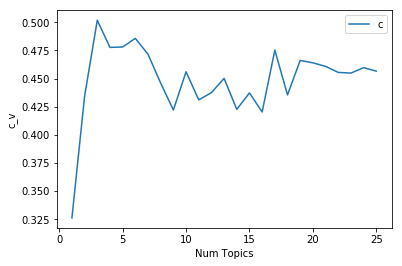

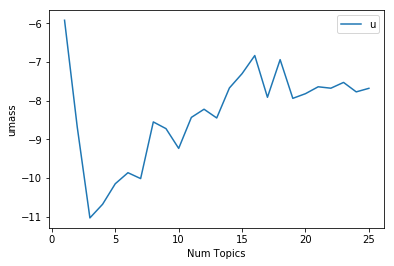

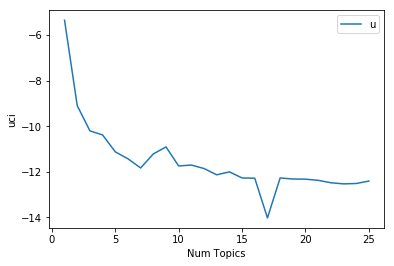

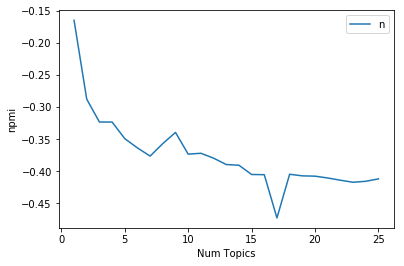

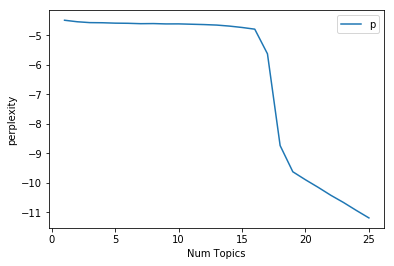

In [281]:
plt.plot(num_topic_list, cv)
plt.xlabel("Num Topics")
plt.ylabel("c_v")
plt.legend(("c_v"), loc='best')
plt.show()

plt.plot(num_topic_list, umass)
plt.xlabel("Num Topics")
plt.ylabel("umass")
plt.legend(("umass"), loc='best')
plt.show()

plt.plot(num_topic_list, uci)
plt.xlabel("Num Topics")
plt.ylabel("uci")
plt.legend(("uci"), loc='best')
plt.show()

plt.plot(num_topic_list, npmi)
plt.xlabel("Num Topics")
plt.ylabel("npmi")
plt.legend(("npmi"), loc='best')
plt.show()

plt.plot(num_topic_list, perplex)
plt.xlabel("Num Topics")
plt.ylabel("perplexity")
plt.legend(("perplexity"), loc='best')
plt.show()

The ''umass' and 'c_v' coherence plots peak for 3 topics. Let's try to visulaize the results with 3 topics and see how the results look.

### <font color=tan>Visualizing and publishing results</font>

In [317]:
ldamodel = Lda(corpus, id2word = dictionary,num_topics = 3,
               random_state = 100, update_every = 5, chunksize = 25,
               passes = 100, alpha = 0.5, per_word_topics = True)

In [318]:
coherence_model_lda_cv = CoherenceModel(model=ldamodel, texts=docs, 
                                         dictionary=dictionary, coherence='c_v')
coherence_lda_cv = coherence_model_lda_cv.get_coherence()
    
coherence_model_lda_umass = CoherenceModel(model=ldamodel, texts=docs, 
                                         dictionary=dictionary, coherence='u_mass')
coherence_lda_umass = coherence_model_lda_umass.get_coherence() 
print(coherence_lda_cv)
print(coherence_lda_umass)
print(coherence_model_lda_cv.get_coherence_per_topic())

0.5017351859537915
-11.028818163357869
[0.6343460477497734, 0.4252922717014408, 0.44556723841016044]


#### <font color=tan> Word Cloud for top 10 words/ngrams in a topic</font>

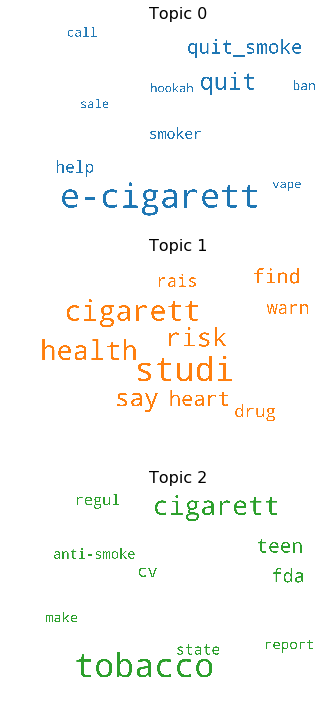

In [321]:
stop_words = set(stopwords.words('english'))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]*4 

cloud = WordCloud(stopwords = stop_words,
                  background_color = 'white',
                  width = 2500,
                  height = 1800,
                  max_words = 10,
                  colormap = 'tab10',
                  color_func=lambda *args, 
                  **kwargs: cols[i],
                  prefer_horizontal = 1.0)

topics = ldamodel.show_topics(num_topics = 30,formatted=False)

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=10, hspace=10)
plt.axis('off')
plt.margins(x= 10, y= 50)
plt.tight_layout()
plt.show()

#### <font color=tan>Writing cluster output</font>

In [322]:
cluster_frame = pd.DataFrame.from_dict({topics[i][1][j]:i for j in range(10) for i in range(3)},orient='index')
cluster_frame = cluster_frame.reset_index()
cluster_frame.columns = ["Word_Tuple","Cluster"]
cluster_frame[['Word','Probability']] = pd.DataFrame(cluster_frame['Word_Tuple'].to_list(), index = cluster_frame.index)
cluster_frame = cluster_frame[['Cluster','Word','Probability']].sort_values(['Cluster','Probability'],ascending = [1, 0])
cluster_frame.to_csv("Task2_Cluster_Outputs.csv", index = False)
ldamodel.show_topics(num_topics=30, formatted = True)

[(0,
  '0.285*"e-cigarett" + 0.119*"quit" + 0.074*"quit_smoke" + 0.051*"help" + 0.043*"smoker" + 0.032*"ban" + 0.031*"call" + 0.028*"sale" + 0.027*"vape" + 0.027*"hookah"'),
 (1,
  '0.090*"studi" + 0.063*"cigarett" + 0.058*"health" + 0.051*"risk" + 0.046*"say" + 0.031*"heart" + 0.030*"find" + 0.023*"warn" + 0.022*"drug" + 0.022*"rais"'),
 (2,
  '0.149*"tobacco" + 0.088*"cigarett" + 0.041*"teen" + 0.038*"fda" + 0.031*"cv" + 0.025*"regul" + 0.023*"state" + 0.021*"report" + 0.020*"anti-smoke" + 0.020*"make"')]

#### <font color = tan>PyLDAvis Visualization</font >
We use the package pyLDA vis to visualize the results for our LDA model. The lambda parameter on the right hand side can be adjusted to get the most unique words for the topic (when lambda is close to 0) and most commonly occuring words (when lambda is close to 1).

In [319]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary = dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.100141 -0.297171  1       1        38.825321
2     -0.233827  0.227203  2       1        36.581024
0      0.333969  0.069968  3       1        24.593662, topic_info=    Category        Freq        Term       Total  loglift  logprob
1    Default  195.000000  e-cigarett  195.000000  30.0000  30.0000
4    Default  152.000000  tobacco     152.000000  29.0000  29.0000
20   Default  81.000000   quit        81.000000   28.0000  28.0000
58   Default  97.000000   studi       97.000000   27.0000  27.0000
42   Default  51.000000   quit_smoke  51.000000   26.0000  26.0000
38   Default  62.000000   health      62.000000   25.0000  25.0000
43   Default  56.000000   risk        56.000000   24.0000  24.0000
6    Default  157.000000  cigarett    157.000000  23.0000  23.0000
63   Default  50.000000   say         50.000000   22.0000  22.0000
19   Default  47.000000   help        47.000000   21.0000  21.0000
14   Default  29.000000   smoker      29.000000   20.0000  20.0000
3    Default  42.000000   teen        42.000000   19.0000  19.0000
96   Default  39.000000   fda         39.000000   18.0000  18.0000
16   Default  22.000000   ban         22.000000   17.0000  17.0000
70   Default  34.000000   heart       34.000000   16.0000  16.0000
13   Default  21.000000   call        21.000000   15.0000  15.0000
74   Default  31.000000   cv          31.000000   14.0000  14.0000
109  Default  32.000000   find        32.000000   13.0000  13.0000
40   Default  19.000000   sale        19.000000   12.0000  12.0000
53   Default  19.000000   vape        19.000000   11.0000  11.0000
71   Default  19.000000   hookah      19.000000   10.0000  10.0000
33   Default  25.000000   regul       25.000000   9.0000   9.0000 
36   Default  16.000000   million     16.000000   8.0000   8.0000 
112  Default  24.000000   state       24.000000   7.0000   7.0000 
22   Default  25.000000   warn        25.000000   6.0000   6.0000 
64   Default  24.000000   drug        24.000000   5.0000   5.0000 
49   Default  24.000000   rais        24.000000   4.0000   4.0000 
48   Default  14.000000   public      14.000000   3.0000   3.0000 
8    Default  23.000000   pack        23.000000   2.0000   2.0000 
89   Default  21.000000   report      21.000000   1.0000   1.0000 
..       ...        ...      ...            ...      ...      ... 
53   Topic3   18.748276   vape        19.409702   1.3680  -3.5953 
40   Topic3   18.868053   sale        19.553965   1.3670  -3.5890 
71   Topic3   18.413000   hookah      19.114166   1.3653  -3.6134 
36   Topic3   16.021959   million     16.770489   1.3570  -3.7525 
48   Topic3   13.862966   public      14.521962   1.3562  -3.8972 
11   Topic3   13.543282   plain       14.237826   1.3527  -3.9206 
10   Topic3   12.494975   packag      13.149233   1.3516  -4.0011 
73   Topic3   12.939971   propos      13.656889   1.3488  -3.9661 
116  Topic3   12.858241   graphic     13.630966   1.3443  -3.9725 
27   Topic3   10.574738   debat       11.226141   1.3429  -4.1680 
59   Topic3   10.201316   regular     10.953288   1.3316  -4.2039 
29   Topic3   13.222456   tri         14.385915   1.3183  -3.9445 
19   Topic3   35.151886   help        47.006592   1.1121  -2.9668 
15   Topic3   12.094783   video       18.442724   0.9808  -4.0337 
107  Topic3   7.645236    healthtalk  11.808780   0.9679  -4.4924 
37   Topic3   5.521038    user        12.234501   0.6070  -4.8179 
47   Topic3   8.222960    could       20.354172   0.4963  -4.4195 
93   Topic3   5.058582    want        12.720270   0.4806  -4.9054 
56   Topic3   5.254945    weight      15.324682   0.3324  -4.8673 
61   Topic3   0.368314    flavour     7.387226   -1.5959  -7.5253 
39   Topic3   0.385659    tough       8.697562   -1.7132  -7.4792 
41   Topic3   0.381994    us          9.053791   -1.7629  -7.4888 
51   Topic3   0.404666    possibl     10.129711  -1.8175  -7.4311 
18

### <font color=tan>Conclusion</font>

**Lets us summarize our observations about few of the sub topics in the topic "Tobacco Use" from the word cloud, printed topics and the pyLDAvis notebook.** *(Topic numbers are consistent with pyLDAvis)*<br>
**Topic 1** : Topic 1 is about studies suggesting heart risk is increased by using tobacco. -- **"Tobacco Use Risks"**<br>
**Topic 2** : Topic 2 suggests FDA is trying to regulate tobacco use in teens using anti-smoking rules. --**"Regulate Tobacco Use"**<br>
**Topic 3** : Topics 3 is about the products that help quit smoking using e-cigarettes, apes and hookahs. --**"How to quit smoking?"**<br>

Overall running several iterations and visualizing each of them using pyLDAvis, I got to know lower value of alpha (typically 0.2-0.6) resulted in topics being differentiable from each other whereas higher values of alpha (>1) resulted in overlapping topics. However, finding the optimal number of topics to be used shall come out from experience of the data and the quantity of data on which the model is being run as the coherence plots peak for more than one value and it becomes difficult to decide on the number of topics just by looking at the coherence plots.